In [1]:
student_id = 401722199#@param {type:"integer"}
student_name = "S.M. Erfan Moosavi M." #@param {type:"string"}

# **MLP From Scratch**

In [2]:
import numpy as np

In [3]:
a = np.arange(-10, 10).T
a
np.maximum(0, a)

array([-10,  -9,  -8,  -7,  -6,  -5,  -4,  -3,  -2,  -1,   0,   1,   2,
         3,   4,   5,   6,   7,   8,   9])

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

## **1.1 Activation Functions**

let's implement some activation functions! Linear, Relu and Sigmoid are the functions that we'll need in this assignment. Note that you should also implement their derivatives since you'll need them later for back-propagation.

In [4]:
## We've implemented the Linear activation function for you
def linear(x, deriv=False):

  return x if not deriv else np.ones_like(x)


def relu(x, deriv=False):
  """
  Args:
    x: A numpy array of any shape 
    deriv: True or False. determines if we want the derivative of the function or not.
    
  Returns:
    relu_out: A numpy array of the same shape as x. 
      Basically relu function or its derivative applied to every element of x
               
  """

  ########################################
  #     Put your implementation here     #
  ######################################## 
  # [Erfan]: numpy's maximum function return the element wise maximum of two array (do broadcast if needed)
  # https://numpy.org/doc/stable/reference/generated/numpy.maximum.html
  # https://numpy.org/doc/stable/reference/generated/numpy.heaviside.html
  
  relu_out = np.maximum(0, x) if not deriv else np.heaviside(x, 1)
  return relu_out
  
def  sigmoid(x, deriv=False):
  """
  Args:
    x: A numpy array of any shape 
    deriv: True or False. determines if we want the derivative of the function or not.
    
  Returns:
    sig_out: A numpy array of the same shape as x. 
      Basically sigmoid function or its derivative applied to every element of x
               
  """

  ########################################
  #     Put your implementation here     #
  ########################################
  sig_out = 1 / (1 + np.exp(-x)) if not deriv else sigmoid(x) * (1 - sigmoid(x))
  return sig_out

In [5]:
# Test your implementation

x_act, relu_out, sig_out = np.load('act_test.npy', allow_pickle=True)
assert np.allclose( relu_out[0], relu(x_act, deriv=True), atol=1e-6, rtol=1e-5) and np.allclose(relu_out[1], relu(x_act, deriv=False), atol=1e-6, rtol=1e-5)
assert np.allclose(sig_out[0], sigmoid(x_act, deriv=True), atol=1e-6, rtol=1e-5) and np.allclose(sig_out[1], sigmoid(x_act, deriv=False), atol=1e-6, rtol=1e-5)

## **1.2 Forward Propagation**

Now let's implement our MLP class. This class handles adding layers and doing the forward propagation. Here are the attributes of this class:
- parameters: A list of dictionaries in the form of {'w': weight, 'b': bias} where weight and bias are weight matrix and bias vector of a layer.
- act_funcs: A list of activation functions used in the corresponding layer.
- activations: A list of matrices each corresponding to the output of each layer.
- weighted_ins: A list of matrices each corresponding to the weighted input of each layer. Weighted input, as the name suggests, is layer's input multiplied by layer's weights and added to layer's bias. Which then goes into the layer's activation function to compute the layer's activations(outputs)!
Note that we store weighted inputs and outputs of the layers because we'll need them later for implementing the back-propagation algorithm.

In [6]:
class MLP:

  def __init__(self, input_dim):
    """
  Args:
    input_dim: An integer determining the inpu dimension of the MLP
               
  """

    self.input_dim = input_dim
    self.parameters = []
    self.act_funcs = []
    self.activations = []
    self.weighted_ins = []

  def add_layer(self, layer_size, act_func=linear):
    """
    Add layers to the MLP using this function
  Args:
    layer_size: An integer determinig the number of neurons in the layer
    act_func: A function applied to the units in the layer 
    
               
  """
    ### Size of the previous layer of mlp
    prev_size = self.input_dim if not self.parameters else self.parameters[-1]['w'].shape[-1]

    ### Weight scale used in He initialization
    weight_scale = np.sqrt(2/prev_size)
    ### initializing the weights and bias of the layer
    weight = np.random.normal(size=(prev_size, layer_size))*weight_scale
    bias = np.ones(layer_size) *0.1
    ### Add weights and bias of the layer to the parameters of the MLP
    self.parameters.append({'w': weight, 'b': bias})
    ### Add the layer's activation function 
    self.act_funcs.append(act_func)



  def feed_forward(self, X):
    """
    Propagate the inputs forward using this function
  Args:
    X: A numpy array of shape (b, input_dim) where b is the batch size and input_dim is the dimension of the input
    
  Returns:
    mlp_out: A numpy array of shape (b, out_dim) where b is the batch size and out_dim is the dimension of the output

    Hint: Don't forget to store weighted inputs and outputs of each layer in self.weighted_ins and self.activations respectively
               
  """
    self.activations = []
    self.weighted_ins = []
    mlp_out = X
    ########################################
    #     Put your implementation here     #   
    ######################################## 
    for i, wb in enumerate(self.parameters):
      w, b = wb['w'], wb['b']
      afunc = self.act_funcs[i]
      wi = mlp_out @ w + b
      self.weighted_ins.append(wi)
      awi = afunc(wi)
      self.activations.append(awi)
      mlp_out = awi
      
    return mlp_out

In [7]:
# Test your implementation
import pickle

x = np.random.normal(size=(512, 100))
mlp = MLP(100)
mlp.add_layer(64, relu)
mlp.add_layer(32, relu)
out = mlp.feed_forward(x)
assert len(mlp.parameters) == 2
assert mlp.activations[0].shape == tuple([512, 64]) and mlp.weighted_ins[0].shape == tuple([512, 64])
assert mlp.activations[1].shape == tuple([512, 32]) and mlp.weighted_ins[1].shape == tuple([512, 32])
assert out.shape == tuple([512, 32])
assert np.array_equal(mlp.activations[-1], out)

x, out, parameters = pickle.load(open('mlptest.pkl', 'rb'))
mlp.parameters = parameters
assert np.allclose( out, mlp.feed_forward(x), atol=1e-6, rtol=1e-5)

## **1.3 Loss Function**

The next step in implementing our MLP is to see how good our network's output  y^  is compared to the target output  y ! This is where the loss function comes in. This function gets  y  and  y^  as its inputs and returns a scaler as its output. This scaler indicates how good current parameters of the network are.
Since you'll be doing a multiclass classification later in this assignment, let's implement the cross-entropy function but to use it in a multiclass setting, the network's outputs must be passed through a softmax activation function and the target output must be in one-hot encoded format.

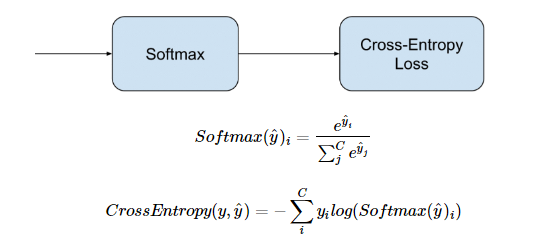


In [8]:
def softmax(y_hat):
  """
    Apply softmax to the inputs
  Args:
    y_hat: A numpy array of shape (b, out_dim) where b is the batch size and out_dim is the output dimension of the network(number of classes) 
    
  Returns:
    soft_out: A numpy array of shape (b, out_dim)
               
  """
  
  ########################################
  #     Put your implementation here     #
  ########################################
  ey = np.exp(y_hat)
  sey = np.sum(ey, axis=1)
  soft_out = ey / sey.reshape((-1, 1))

  return soft_out

In [9]:
y_hat = np.random.normal(size=(100, 5))
y_soft = softmax(y_hat)
assert y_hat.shape == y_soft.shape
assert all([(y - 1.)<1e-5 for y in np.sum(y_soft, axis=1)])
y_hat = np.array([[10,10,10,10], [0,0,0,0]])
assert np.allclose( softmax(y_hat), np.array([[0.25, 0.25, 0.25, 0.25], [0.25, 0.25, 0.25, 0.25]]), atol=1e-6, rtol=1e-5)

Now implement the categorical cross-entropy function ("categorical" refers to multiclass classification). Note that the inputs are in batches, so the loss of a batch of samples will be the average of losses of samples in the batch.

In [10]:
def categorical_cross_entropy(y, y_soft):
  """
    Compute the categorical cross entropy loss
  Args:
    y: A numpy array of shape (b, out_dim). Target labels of network.
    y_soft: A numpy array of shape (b, out_dim). Output of the softmax activation function
    
  Returns:
    loss: A scaler of type float. Average loss over a batch.

  Hint: Use np.mean to compute average loss of a batch
               
  """

  ########################################
  #     Put your implementation here     #
  ########################################
  ls = np.log(y_soft)
  yls = y * ls
  loss = -np.mean(np.sum(yls, axis=1))

  return loss

In [11]:
# Test your implementation

y = np.array([[1,0,0], [0,0,1], [1,0,0], [0,1,0]])
y_hat = np.array([[10,1,1], [0,-1,9], [100,-9,9], [0.1,12,10]])
y_soft = softmax(y_hat)
assert round(categorical_cross_entropy(y, y_soft), 3) == 0.032

In [12]:
def softmax_categorical_cross_entropy(y, y_hat, return_grad=False):
  """
    Compute the softmax categorical cross entropy loss
  Args:
    y: A numpy array of shape (b, out_dim). Target labels of network.
    y_hat: A numpy array of shape (b, out_dim). Output of the output layer of the network
    return_grad: If True return gradient of the loss with respect to y_hat. If False just return the loss
    
  Returns:
    loss: A scaler of type float. Average loss over a batch.
               
  """
  
  y_soft = softmax(y_hat)
  
  if not return_grad:
    loss = categorical_cross_entropy(y, y_soft)
    return loss
  else:
    loss_grad = (y_soft - y)/y.shape[0]
    return loss_grad

## **1.4 Back-Propagation**

After calculating the loss of the MLP, we need to propagate this loss back to the hidden layers in order to calculate the gradient of the loss with respect to the weights and biases of the network.

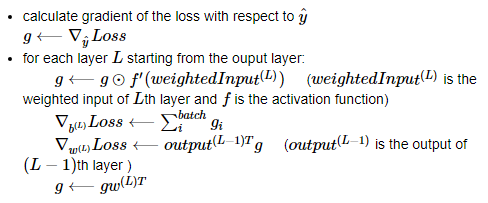

In [13]:
def mlp_gradients(mlp, loss_function, x, y):
  """
    Compute the gradient of loss with respect to mlp's weights and biases
  Args:
    mlp: An object of MLP class
    loss_function: A function used as loss function of the MLP
    x: A numpy array of shape (batch_size, input_dim). The MLP's input
    y: A numpy array of shape (batch_size, num_classes). Target labels
    
  Returns:
    gradients: A list of dictionaries {'w': dw, 'b': db} corresponding to the dictionaries in mlp.parameters
        dw is the gradient of loss with respect to the weights of the layer 
        db is the gradient of loss with respect to the bias of the layer 
               
  """  

  gradients = []

  ### get the output of the network
  y_hat = mlp.activations[-1]
  num_layers = len(mlp.parameters)

  ### compute gradient of the loss with respect to network output
  g = loss_function(y, y_hat, return_grad=True)

  ### You'll need the input in the last step of backprop so let's make a new list with x in the beginning
  activations = [x] + mlp.activations 
  
  for i in reversed(range(num_layers)):
    ########################################
    #     Put your implementation here     #
    ########################################
    
    afunc = mlp.act_funcs[i]
    wi = mlp.weighted_ins[i]
    act = activations[i].T
    w = mlp.parameters[i]['w'].T
    
    g *= afunc(wi, True)
    
    db = np.sum(g, axis=0)
    dw = act.dot(g)
    
    g = g.dot(w)
    
    grad = {
      'w':dw, 
      'b':db
    }
    gradients.insert(0, grad)
    
  return gradients

unzip grad_test.zip

In [14]:
# Test your implementation

import pickle
x = np.load('grad_x.npy')
y = np.load('grad_y.npy')
mlp = pickle.load(open('grad_mlp_test.pkl', 'rb'))
expected_grads = pickle.load(open('grads', 'rb'))
_ = mlp.feed_forward(x)
grads = mlp_gradients(mlp, softmax_categorical_cross_entropy, x, y)
assert all([np.allclose(eg['w'], g['w'], atol=1e-6, rtol=1e-5) and 
            np.allclose(eg['b'], g['b'], atol=1e-6, rtol=1e-5) 
            for eg, g in zip(expected_grads, grads)])

## **1.5 Optimization**

Now we should optimize these parameters using the gradients in order for the network to produce better outputs.
Gradient descent is an optimizaion method that iteratively moves the paramters in the oposite direction of their gradients. Below is the update rule for gradient descent:

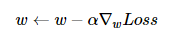



In [15]:
x = np.random.normal(size=(16, 10))
y = np.eye(16)
lr = 0.1
### Define the mlp 
mlp = MLP(x.shape[-1])
mlp.add_layer(16)
mlp.add_layer(8)
mlp.add_layer(y.shape[-1])
### compute mlp's output
y_hat = mlp.feed_forward(x)
### print current loss
print("loss before gradient descent: ", softmax_categorical_cross_entropy(y, y_hat))
### Compute gradients of the mlp's parameters 
grads = mlp_gradients(mlp, softmax_categorical_cross_entropy, x, y)
### perform gradient descent
mlp.parameters = [{'w':p['w']-lr*g['w'], 'b':p['b']-lr*g['b']} for g, p in zip(grads, mlp.parameters)]
### compute mlp's output again after gradeint descent
y_hat = mlp.feed_forward(x)
### print loss after gradient descent
print("loss after gradient descent: ", softmax_categorical_cross_entropy(y, y_hat))

loss before gradient descent:  6.318076214387002
loss after gradient descent:  4.4011895148168225


Now let's implement SGD class with momentum

In [176]:
class SGD:

  def __init__(self, lr=0.01, momentum=0.9):
    """
  Args:
    lr: learning rate of the SGD optimizer
    momentum: momentum of the SGD optimizer

    Hint: velocity should be a list of dictionaries just like mlp.parameters
               
  """ 

    self.lr = lr
    self.momentum = momentum
    ### initialize velocity
    self.velocity = []
  
  def step(self, parameters, grads):

    """
    Perform a gradient descent step
  Args:
    parameters: A list of dictionaries {'w': weights , 'b': bias}. MLP's parameters. 
    grads: A list of dictionaries {'w': dw, 'b': db}. gradient of MLP's parameters. Basically the output of "mlp_gradients" function you implemented!
    
  Returns:
    Updated_parameters: A list of dictionaries {'w': weights , 'b': bias}. mlp's parameters after performing a step of gradient descent. 
               
  """

    ########################################
    #     Put your implementation here     #
    ######################################## 
    # https://machinelearningmastery.com/gradient-descent-with-momentum-from-scratch/
    
    self.velocity = [{'w':0, 'b':0} for i in range(len(parameters))]
    Updated_parameters = [{'w':0, 'b':0} for i in range(len(parameters))]
    
    for i in range(len(parameters)):
      wb = parameters[i]
      dwb = grads[i]
      vel = self.velocity[i]
      
      change_gdw = self.lr * dwb['w']
      change_gdb = self.lr * dwb['b']
      change_mw = self.momentum * vel['w']
      change_mb = self.momentum * vel['b']
      
      change_w = change_gdw + change_mw
      change_b = change_gdb + change_mb
      
      self.velocity[i]['w'] = change_w
      self.velocity[i]['b'] = change_b
      
      Updated_parameters[i]['w'] = wb['w'] - change_w
      Updated_parameters[i]['b'] = wb['b'] - change_b
      
    return Updated_parameters

# **2.Classifying Kannada Handwritten Digits**

In this part of the assignment, you'll use the MLP you implemented in the first part to classify Kannada handwritten digits!
This dataset consists of 60000 images of handwritten digits in Kannada script.
You can check [this](https:https://github.com/vinayprabhu/Kannada_MNIST) github repository for more information about the dataset.
unzip kannada.zip

In [17]:
import pandas as pd
import matplotlib.pyplot as plt
train = pd.read_csv('train.csv')

In [18]:
train.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


As you can see, the first column of the dataframe is the label, and the rest of the columns are the pixels. Let's put the dataset in numpy arrays. Also, we must normalize the pixel values to [0,1] range to help the convergence of our MLP model.

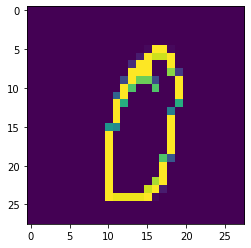

In [19]:
x = train.values[:, 1:]/255.
y = train.values[:, 0]
plt.imshow(x[10000].reshape(28, 28))

As we are doing a multiclass classification, the labels must be in one-hot encoded format.

In [20]:
def one_hot_encoder(y):

  y = y.reshape(-1)
  num_samples = y.shape[0]
  max_label = np.max(y)
  one_hot = np.zeros((num_samples, max_label+1))
  one_hot[np.arange(num_samples),y] = 1
  
  return one_hot

In [21]:
y = one_hot_encoder(y)

This function transforms the dataset into multiple batches. We need this function because we'll be doing mini-batch gradient descent.

In [22]:
import math

def get_mini_batches(x, y, batch_size, shuffle=True):

  idx = list(range(len(x)))
  np.random.shuffle(idx)
  steps = math.ceil(len(x)/batch_size)
  x, y = x[idx, :], y[idx, :]
  for i in range(steps):
    yield (x[i*batch_size: (i+1)*batch_size], y[i*batch_size: (i+1)*batch_size])

In [23]:
def accuracy(y, y_hat):

  return np.mean(np.argmax(y, axis=-1)==np.argmax(y_hat, axis=-1))

Now let's split the dataset into train and validatoin sets:

In [24]:
from sklearn.model_selection import train_test_split

x_train, x_val, y_train, y_val = train_test_split(x, y, stratify=y)

Create your MLP model in the cell bellow. The choice of the number of layers, their sizes and their activation functions is up to you.

In [49]:
mlp = MLP(x_train.shape[-1])

########################################
#     Put your implementation here     #
########################################

mlp.add_layer(256, relu) # hidden 1
mlp.add_layer(128, relu) # hidden 2
# if you set out put activation as linear, the model conveges with less than 10 epochs
mlp.add_layer(10, sigmoid) # output

Feel free to change these hyper-parameters.

In [50]:
epochs = 50
Batch_size = 1024
sgd_lr = 0.1
sgd_momentum = 0.9

Now let's train the network!

In [51]:
from tqdm import tqdm_notebook
### Defining a optimizer
optimizer = SGD(lr=sgd_lr, momentum=sgd_momentum)

train_loss, val_loss, train_accs, val_accs = [], [], [], []

for i in range(epochs):
  mini_batches = get_mini_batches(x_train, y_train, Batch_size)
  for xx, yy in tqdm_notebook(mini_batches, desc='epoch {}'.format(i+1)):

    ### forward propagation
    _ = mlp.feed_forward(xx)
    ### compute gradients
    grads = mlp_gradients(mlp, softmax_categorical_cross_entropy, xx, yy)
    ### optimization
    mlp.parameters = optimizer.step(mlp.parameters, grads)
    
  y_hat = mlp.feed_forward(x_train)
  y_hat_val = mlp.feed_forward(x_val)
  val_loss.append(softmax_categorical_cross_entropy(y_val, y_hat_val))
  train_loss.append(softmax_categorical_cross_entropy(y_train, y_hat))
  train_acc = accuracy(y_train, y_hat)*100
  val_acc = accuracy(y_val, y_hat_val)*100
  train_accs.append(train_acc)
  val_accs.append(val_acc)
  print("training acc: {:.2f} %".format(train_acc))
  print("test acc: {:.2f} %".format(val_acc))

C:\Users\smerf\AppData\Local\Temp\ipykernel_8204\426872586.py:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for xx, yy in tqdm_notebook(mini_batches, desc='epoch {}'.format(i+1)):


epoch 1: 0it [00:00, ?it/s]

training acc: 71.30 %
test acc: 71.73 %


epoch 2: 0it [00:00, ?it/s]

training acc: 83.78 %
test acc: 84.21 %


epoch 3: 0it [00:00, ?it/s]

training acc: 86.69 %
test acc: 86.96 %


epoch 4: 0it [00:00, ?it/s]

training acc: 88.19 %
test acc: 88.38 %


epoch 5: 0it [00:00, ?it/s]

training acc: 89.17 %
test acc: 89.48 %


epoch 6: 0it [00:00, ?it/s]

training acc: 89.84 %
test acc: 90.32 %


epoch 7: 0it [00:00, ?it/s]

training acc: 90.44 %
test acc: 90.85 %


epoch 8: 0it [00:00, ?it/s]

training acc: 90.96 %
test acc: 91.23 %


epoch 9: 0it [00:00, ?it/s]

training acc: 91.26 %
test acc: 91.57 %


epoch 10: 0it [00:00, ?it/s]

training acc: 91.65 %
test acc: 91.93 %


epoch 11: 0it [00:00, ?it/s]

training acc: 91.90 %
test acc: 92.11 %


epoch 12: 0it [00:00, ?it/s]

training acc: 92.17 %
test acc: 92.37 %


epoch 13: 0it [00:00, ?it/s]

training acc: 92.42 %
test acc: 92.57 %


epoch 14: 0it [00:00, ?it/s]

training acc: 92.66 %
test acc: 92.81 %


epoch 15: 0it [00:00, ?it/s]

training acc: 92.85 %
test acc: 92.99 %


epoch 16: 0it [00:00, ?it/s]

training acc: 93.08 %
test acc: 93.19 %


epoch 17: 0it [00:00, ?it/s]

training acc: 93.35 %
test acc: 93.43 %


epoch 18: 0it [00:00, ?it/s]

training acc: 93.55 %
test acc: 93.66 %


epoch 19: 0it [00:00, ?it/s]

training acc: 93.68 %
test acc: 93.77 %


epoch 20: 0it [00:00, ?it/s]

training acc: 93.86 %
test acc: 93.97 %


epoch 21: 0it [00:00, ?it/s]

training acc: 94.02 %
test acc: 94.10 %


epoch 22: 0it [00:00, ?it/s]

training acc: 94.09 %
test acc: 94.15 %


epoch 23: 0it [00:00, ?it/s]

training acc: 94.20 %
test acc: 94.24 %


epoch 24: 0it [00:00, ?it/s]

training acc: 94.36 %
test acc: 94.41 %


epoch 25: 0it [00:00, ?it/s]

training acc: 94.44 %
test acc: 94.49 %


epoch 26: 0it [00:00, ?it/s]

training acc: 94.59 %
test acc: 94.65 %


epoch 27: 0it [00:00, ?it/s]

training acc: 94.66 %
test acc: 94.71 %


epoch 28: 0it [00:00, ?it/s]

training acc: 94.77 %
test acc: 94.79 %


epoch 29: 0it [00:00, ?it/s]

training acc: 94.81 %
test acc: 94.83 %


epoch 30: 0it [00:00, ?it/s]

training acc: 94.92 %
test acc: 94.93 %


epoch 31: 0it [00:00, ?it/s]

training acc: 94.96 %
test acc: 94.93 %


epoch 32: 0it [00:00, ?it/s]

training acc: 95.04 %
test acc: 95.03 %


epoch 33: 0it [00:00, ?it/s]

training acc: 95.05 %
test acc: 95.04 %


epoch 34: 0it [00:00, ?it/s]

training acc: 95.14 %
test acc: 95.16 %


epoch 35: 0it [00:00, ?it/s]

training acc: 95.16 %
test acc: 95.16 %


epoch 36: 0it [00:00, ?it/s]

training acc: 95.23 %
test acc: 95.23 %


epoch 37: 0it [00:00, ?it/s]

training acc: 95.29 %
test acc: 95.26 %


epoch 38: 0it [00:00, ?it/s]

training acc: 95.33 %
test acc: 95.33 %


epoch 39: 0it [00:00, ?it/s]

training acc: 95.39 %
test acc: 95.35 %


epoch 40: 0it [00:00, ?it/s]

training acc: 95.42 %
test acc: 95.38 %


epoch 41: 0it [00:00, ?it/s]

training acc: 95.48 %
test acc: 95.43 %


epoch 42: 0it [00:00, ?it/s]

training acc: 95.50 %
test acc: 95.48 %


epoch 43: 0it [00:00, ?it/s]

training acc: 95.58 %
test acc: 95.53 %


epoch 44: 0it [00:00, ?it/s]

training acc: 95.64 %
test acc: 95.57 %


epoch 45: 0it [00:00, ?it/s]

training acc: 95.65 %
test acc: 95.55 %


epoch 46: 0it [00:00, ?it/s]

training acc: 95.67 %
test acc: 95.63 %


epoch 47: 0it [00:00, ?it/s]

training acc: 95.67 %
test acc: 95.63 %


epoch 48: 0it [00:00, ?it/s]

training acc: 95.74 %
test acc: 95.70 %


epoch 49: 0it [00:00, ?it/s]

training acc: 95.80 %
test acc: 95.73 %


epoch 50: 0it [00:00, ?it/s]

training acc: 95.77 %
test acc: 95.76 %


Let's visualize accuracy and loss for train and validation sets during training:

Text(0.5, 0, 'epoch')

Text(0, 0.5, 'loss')

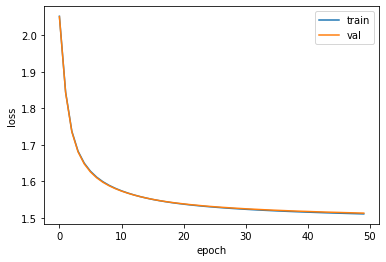

In [52]:
plt.plot(list(range(len(train_loss))), train_loss, label='train')
plt.plot(list(range(len(val_loss))), val_loss, label='val')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show()

Text(0.5, 0, 'epoch')

Text(0, 0.5, 'accuracy')

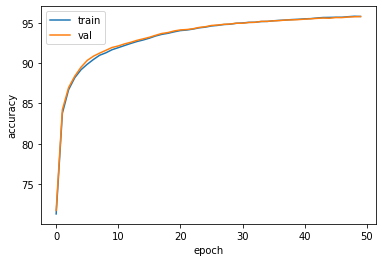

In [53]:
plt.plot(list(range(len(train_accs))), train_accs, label='train')
plt.plot(list(range(len(val_accs))), val_accs, label='val')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend()
plt.show()

# 3.Mnist Keras Implementation (optional)

In [58]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Input

In [66]:
# https://keras.io/guides/sequential_model/
# https://www.kdnuggets.com/2018/06/basic-keras-neural-network-sequential-model.html

model = Sequential(
    [
        Input(784),
        Dense(256, activation='relu'),
        Dropout(0.5),
        Dense(128, activation="relu"),
        Dropout(0.5),
        Dense(10, activation='softmax'),
    ]
)

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [67]:
model.fit(x_train, y_train,
          batch_size=1024,
          epochs=10,
          verbose=1,
          validation_data=(x_val, y_val))

Epoch 1/10
44/44 [==============================] - 2s 31ms/step - loss: 1.0016 - accuracy: 0.6832 - val_loss: 0.2012 - val_accuracy: 0.9427
Epoch 2/10
44/44 [==============================] - 1s 24ms/step - loss: 0.2771 - accuracy: 0.9178 - val_loss: 0.1324 - val_accuracy: 0.9607
Epoch 3/10
44/44 [==============================] - 1s 23ms/step - loss: 0.2019 - accuracy: 0.9402 - val_loss: 0.1115 - val_accuracy: 0.9673
Epoch 4/10
44/44 [==============================] - 1s 22ms/step - loss: 0.1644 - accuracy: 0.9525 - val_loss: 0.0988 - val_accuracy: 0.9713
Epoch 5/10
44/44 [==============================] - 1s 23ms/step - loss: 0.1392 - accuracy: 0.9594 - val_loss: 0.0889 - val_accuracy: 0.9733
Epoch 6/10
44/44 [==============================] - 1s 22ms/step - loss: 0.1208 - accuracy: 0.9647 - val_loss: 0.0823 - val_accuracy: 0.9746
Epoch 7/10
44/44 [==============================] - 1s 22ms/step - loss: 0.1087 - accuracy: 0.9682 - val_loss: 0.0751 - val_accuracy: 0.9765
Epoch 8/10
44

In [68]:
score = model.evaluate(x_val, y_val, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.06273923069238663
Test accuracy: 0.9814666509628296


In [157]:
# Ex 2, Implementation

P1 = [[1,0,0,1], [0,1,1,0], [0,1,1,0], [1,0,0,1]]
P2 = [[1,0,0,1], [0,1,1,0], [0,1,1,0], [0,1,1,0]]
P3 = [[1,1,1,1], [0,0,1,0], [0,1,0,0], [1,1,1,1]]

A1 = np.array(P1)
A2 = np.array(P2)

B1 = np.abs(np.array(P1) - 1)
B2 = np.abs(np.array(P2) - 1)

T = np.array(P3)

X_train = np.array([A1.flatten(), B1.flatten(), A2.flatten(), B2.flatten()])
y_train = np.array([-1, 1, -1, 1])
X_test = np.array([T.flatten()])

In [175]:
model = Sequential(
    [
        Input(16),
        Dense(1, activation='tanh'),
    ]
)

model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy', metrics=['accuracy'])

model.fit(X_train, y_train,
          batch_size=4,
          epochs=20,
          verbose=0,
          shuffle=False)

p = model.predict(X_train)
print(f'Predictions: \n{p}')
print(f'Smoothed Predictions: \n{np.sign(p)}')

y_train == np.sign(p).T

print('If the following output is negative, it means Group A, and it is expected.')
print(model.predict(X_test))


1/1 [==============================] - 0s 52ms/step
Predictions: 
[[-0.25788134]
 [ 0.23779766]
 [-0.8927961 ]
 [ 0.88837004]]
Smoothed Predictions: 
[[-1.]
 [ 1.]
 [-1.]
 [ 1.]]


array([[ True,  True,  True,  True]])

If the following output is negative, it means Group A, and it is expected.
1/1 [==============================] - 0s 29ms/step
[[-0.79156524]]
